In [1]:
import pandas as pd
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt


# Making Datasets

In [4]:
X,y = make_circles(n_samples=1000, noise=0.1, random_state=42)
len(X), len(y)


(1000, 1000)

In [5]:
print(f"First 10 exmaples of X:\n {X[:10]}")
print(f"First 10 exmaples of y:\n {y[:10]}")

First 10 exmaples of X:
 [[ 0.71210844  0.28469831]
 [-0.67871584  0.20727355]
 [-0.86602567  0.34365139]
 [-0.51764775  0.62059874]
 [ 0.4540887  -0.89046586]
 [-0.44548328  0.78704416]
 [-0.02203792  0.81130978]
 [ 0.72989715  0.18894258]
 [-0.19161584 -0.81578974]
 [-0.08344198  1.09395352]]
First 10 exmaples of y:
 [1 1 1 1 0 1 1 1 1 0]


In [7]:
circles = pd.DataFrame({"X1":X[:,0], "X2":X[:,1], "label":y})
circles.head(10)

,X1,X2,label
0,0.712108,0.284698,1
1,-0.678716,0.207274,1
2,-0.866026,0.343651,1
3,-0.517648,0.620599,1
4,0.454089,-0.890466,0
5,-0.445483,0.787044,1
6,-0.022038,0.811310,1
7,0.729897,0.188943,1
8,-0.191616,-0.815790,1
9,-0.083442,1.093954,0


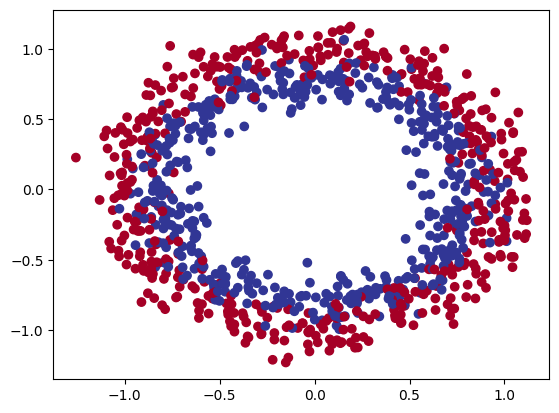

In [10]:
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)